In [1]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("../sales_train.csv.gz")
test_df  = pd.read_csv("../test.csv.gz")

categories = pd.read_csv('../item_categories.csv')
items = pd.read_csv('../items.csv')

In [2]:
%store -r __prepare_data

In [3]:
%%time
__prepare_data

CPU times: user 1min 32s, sys: 44.6 s, total: 2min 16s
Wall time: 2min 19s


I saw the date filed has the month and day fields mixed up in the format for some entries, hence I reassign date using date_block_num

In [4]:
from calendar import monthrange

# January, 2013 is date_block_num==0
timeline = pd.DataFrame({'begin_date': pd.date_range(start='2013-01-01',end='2015-11-01', freq='MS'),
                         'date_block_num': range(35)} )
    
timeline['n_days'] = timeline.begin_date.apply(lambda date: monthrange(date.year,date.month)[1])

Let us for now work with zero-suppressed dataframe of monthly sales

In [5]:
monthly = train_df.groupby(["item_id","shop_id","date_block_num"]).item_cnt_day.sum()
monthly = monthly.reset_index()
monthly.columns = ["item_id","shop_id","date_block_num","target"]

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
shop_monthly_sales = monthly.groupby(["shop_id","date_block_num"]).target.sum().reset_index("shop_id")
shop = 19
sales = shop_monthly_sales[shop_monthly_sales.shop_id==shop]
sales_ts = pd.merge(timeline[0:-1], sales, how='left', on=['date_block_num'])
sales_ts = sales_ts.fillna(0)
ts = pd.Series(sales_ts.target.values, index=sales_ts["begin_date"])
decomposition = seasonal_decompose(ts, extrapolate_trend=1, freq=12)

trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


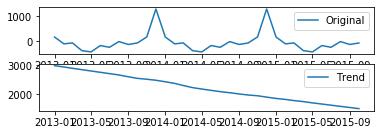

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.subplot(411)
plt.plot(seasonal, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

CPU times: user 673 ms, sys: 81.6 ms, total: 754 ms
Wall time: 789 ms


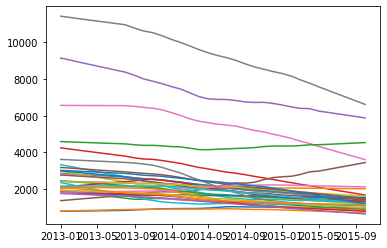

In [8]:
%%time
from statsmodels.tsa.seasonal import seasonal_decompose

shop_monthly_sales = monthly.groupby(["shop_id","date_block_num"]).target.sum().reset_index("shop_id")

decomposition_shop = pd.DataFrame()

closed_shops = []

for shop in shop_monthly_sales.shop_id.unique():

    sales = shop_monthly_sales[shop_monthly_sales.shop_id==shop]
    sales_ts = pd.merge(timeline[0:-1], sales, how='left', on=['date_block_num'])

    # some shop close and open/reopen, don't forecast those yet?
    if any(sales_ts.target.isnull()) :
        closed_shops.append(shop)
        continue

    sales_ts = sales_ts.fillna(0) # not needed with the check above

    ts = pd.Series(sales_ts.target.values, index=sales_ts["begin_date"])

    decomposition = seasonal_decompose(ts, extrapolate_trend=1, freq=12)

    trend    = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.plot(trend, label='Trend')
    decomposition_shop = pd.concat([decomposition_shop,
                             pd.DataFrame({
                                 'date_block_num':  sales_ts.date_block_num,
                                 'shop_id':         [shop]*len(ts),
                                 'shop_trend':      trend.values,
                                 'shop_seasonal':   seasonal.values,
                                 'shop_forecast':   trend.values + seasonal.values
                             })])

In [9]:
extrapolate = lambda x: np.poly1d( np.polyfit([1,2,3], [x.iloc[-3],x.iloc[-2],x.iloc[-1]], 1) )(4)
#extrapolate.__name__ = "shop_trend"

trend_34 = decomposition_shop.groupby(["shop_id"]).agg({"shop_trend": [extrapolate]})
trend_34.columns = ["shop_trend"]
trend_34.reset_index()

seasonal_22 = decomposition_shop[decomposition_shop.date_block_num==(34-12)][['shop_id','shop_seasonal']]

forecast_34 = pd.merge(trend_34, seasonal_22, how='inner', on=['shop_id'])
forecast_34['date_block_num'] = 34
forecast_34['shop_forecast'] = forecast_34['shop_trend'] + forecast_34['shop_seasonal']

decomposition_shop = pd.concat([decomposition_shop, forecast_34], sort=True, ignore_index=True)

34       841.020255
35       753.381366
36       900.061921
37       669.798032
38       731.214699
39       764.228588
40       686.075810
41       849.756366
42       960.089699
43       802.423032
44      1018.027199
45      1212.506366
46       950.686921
47       853.589699
48       986.520255
49       742.506366
50       796.798032
51       828.061921
52       744.659144
53       891.589699
54       971.923032
55       793.714699
56      1005.402199
57      1186.923032
58       905.936921
59       787.673032
60       904.061921
61       645.339699
62       674.631366
63       677.353588
64       568.909144
65       702.298032
66       784.631366
67       600.506366
1089     792.985532
Name: shop_forecast, dtype: float64

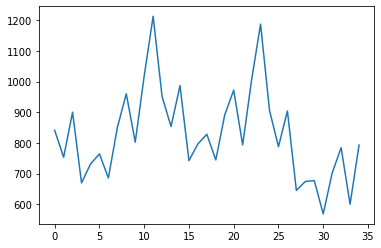

In [10]:
plt.plot(decomposition_shop[decomposition_shop.shop_id==3].shop_forecast.ravel(), label='QWE')
decomposition_shop[decomposition_shop.shop_id==3].shop_forecast

In [11]:
print(closed_shops)
all_data[all_data.shop_id==8].date_block_num.unique()
#forecast_34

[0, 1, 5, 8, 9, 10, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 34, 36, 39, 40, 43, 48, 49, 51, 54, 55, 57, 58]


array([0, 1, 2, 3])

In [12]:
#extrapolate_closed_shops = pd.DataFrame()
#
#for shop in closed_shops:
#
#    sales = shop_monthly_sales[shop_monthly_sales.shop_id==shop]
#    sales_ts = pd.merge(timeline[0:-1], sales, how='left', on=['date_block_num'])
#
#    if sum( sales_ts[-4:].target.isnull() ) == 4:
#        closed_for_good.add(shop)
#        extrapolate_closed_shops = pd.concat([extrapolate_shop,
#                             pd.DataFrame({
#                                 'date_block_num':  range(35),
#                                 'shop_id':         [shop]*35,
#                                 'shop_forecast':   [0]*35
#                             })])
#        continue
#
#    if any(np.isnan(sales_ts.target)):
#        start = min( np.where(~ np.isnan(sales_ts.target))[0] )
#        end   = max( np.where(~ np.isnan(sales_ts.target))[0] )
#        print((shop,end))
#        if end != 33:
#            closed_shops.append(shop)
#            continue
#        sales_ts = sales_ts[start:]
#
#    # at this point first and last observations are not zeros, let's bridge the gaps
#    sales_ts.target = sales_ts.target.interpolate()
#
#    if len(sales_ts) <= 12:
#        closed_shops.append(shop)
#        continue

In [13]:
all_good_data = pd.merge(all_data, decomposition_shop, how='left', on=['date_block_num','shop_id'])
all_bad_data  = all_data[all_data.shop_id.isin(closed_shops)]

In [ ]:
all_good_data.shop_id.

In [14]:
train_good = all_good_data[(all_good_data.date_block_num>12)&(all_good_data.date_block_num<34)].fillna(0)
train_bad  = all_bad_data [(all_bad_data.date_block_num >12)&(all_bad_data.date_block_num <34)].fillna(0)

X_train_bad = train_bad[train_bad.date_block_num <  33][predictors]
X_valid_bad = train_bad[train_bad.date_block_num == 33][predictors]
y_train_bad = train_bad[train_bad.date_block_num <  33].target
y_valid_bad = train_bad[train_bad.date_block_num == 33].target

predictors_good = predictors + ['shop_trend', 'shop_seasonal', 'shop_forecast'] 

X_train_good = train_good[train_good.date_block_num <  33][predictors_good]
X_valid_good = train_good[train_good.date_block_num == 33][predictors_good]
y_train_good = train_good[train_good.date_block_num <  33].target
y_valid_good = train_good[train_good.date_block_num == 33].target

In [15]:
%%time
from sklearn.ensemble import RandomForestRegressor

model_good = RandomForestRegressor(n_estimators=64, max_features=4, n_jobs=4)
model_good.fit(X_train_good, y_train_good)

model_bad = RandomForestRegressor(n_estimators=64, max_features=4, n_jobs=4)
model_bad.fit(X_train_bad, y_train_bad)

CPU times: user 47min 33s, sys: 47.1 s, total: 48min 20s
Wall time: 14min 45s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [20]:
from sklearn.metrics import mean_squared_error

ypred_good = model_good.predict(X_valid_good)
rmse = np.sqrt(mean_squared_error(y_valid_good, ypred_good))
print("RMSE good: %f" % (rmse))
print("Average good: {0}".format(np.mean(ypred_good)))

ypred_bad = model_bad.predict(X_valid_bad)
rmse = np.sqrt(mean_squared_error(y_valid_bad, ypred_bad))
print("RMSE bad: %f" % (rmse))
print("Average bad: {0}".format(np.mean(ypred_bad)))

RMSE good: 0.963775
Average good: 0.267501478977583
RMSE bad: 1.078285
Average bad: 0.21905700383219434


In [21]:
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(X_valid_good.columns, model_good.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                                              score
total_monthly_item_sales_lag_1                0.383324
total_monthly_shop_category_sales_lag_1       0.0875665
total_monthly_shop_subcategory_sales_lag_1    0.0817496
target_lag_1                                  0.067375
total_monthly_category_sales_lag_1            0.0406489
total_monthly_shop_sales_lag_1                0.0388709
total_monthly_subcategory_sales_lag_1         0.0387234
total_monthly_shop_supercategory_sales_lag_1  0.0381761
target_lag_3                                  0.0323462
target_lag_2                                  0.0314675
shop_forecast                                 0.027213
total_monthly_supercategory_sales_lag_1       0.0262801
shop_trend                                    0.0247276
target_lag_6                                  0.0237539
shop_seasonal                                 0.0206978
target_lag_12                                 0.0188342
total_monthly_sales_lag_1                     0.018

In [22]:
%%time
from sklearn.ensemble import RandomForestRegressor
full_model_good = RandomForestRegressor(n_estimators=64, max_features=4, n_jobs=6) #len(predictors)/2
full_model_good.fit(train_good[predictors_good], train_good.target)

full_model_bad = RandomForestRegressor(n_estimators=64, max_features=4, n_jobs=6) #len(predictors)/2
full_model_bad.fit(train_bad[predictors], train_bad.target)

CPU times: user 49min 21s, sys: 47.2 s, total: 50min 8s
Wall time: 15min 6s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=6,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [23]:
month_34_good = all_good_data[all_good_data.date_block_num == 34].fillna(0)
month_34_good['item_cnt_month'] = full_model_good.predict(month_34_good[predictors_good])

month_34_bad = all_bad_data[all_bad_data.date_block_num == 34].fillna(0)
month_34_bad['item_cnt_month'] = full_model_bad.predict(month_34_bad[predictors])

month_34 = pd.concat([month_34_good, month_34_bad], ignore_index=True)

test = pd.merge(test_df, month_34, on=["shop_id","item_id"]).fillna(0)

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"].round().astype("int64")

test[test.item_cnt_month>20] = 20
test.to_csv("shop_trends.csv")

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


Now let us do the same for items

CPU times: user 2min 8s, sys: 2.7 s, total: 2min 11s
Wall time: 2min 11s


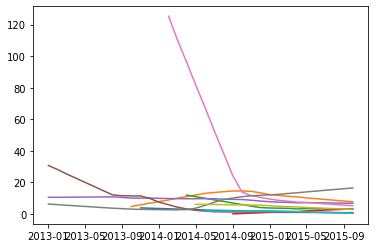

In [17]:
%%time
#import matplotlib.pyplot as plt
#%matplotlib inline

item_monthly_sales = monthly.groupby(["item_id","date_block_num"]).target.sum().reset_index("item_id")

extrapolate_item = pd.DataFrame()

no_stock_items = []

little_data_items = []

for item in item_monthly_sales.item_id.unique():
    
    sales = item_monthly_sales[item_monthly_sales.item_id==item]
    sales_ts = pd.merge(timeline[0:-1], sales, how='left', on=['date_block_num'])

    # some items are discuntinued or go out of stock, don't forecast those yet
    if sum( np.isnan(sales_ts[-3:].target) ) == 3: # >0 ?
        no_stock_items.append(item)
        continue

    # at this point last observations are not zeros, let's bridge the gaps
    sales_ts.target = sales_ts.target.interpolate()
    # last missing values (if any) are automatically imputed with their lags above

    # any remaining nulls are from earliy continuous periods (interpolate wont impute those)
    if any(np.isnan(sales_ts.target)):
        last_null = max( np.where(np.isnan(sales_ts.target))[0] )
        sales_ts = sales_ts[last_null+1:]

    if len(sales_ts) <= 12:
        little_data_items.append(item)
        continue

    ts = pd.Series(sales_ts.target.values, index=sales_ts["begin_date"])

    if any( ts.isnull() ):
        print("Problem")
        break

    decomposition = seasonal_decompose(ts, extrapolate_trend=1, freq=12)

    trend    = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    if item%500 == 0:
        plt.plot(trend, label='Trend')

    extrapolate_item = pd.concat([extrapolate_item,
                             pd.DataFrame({
                                 'date_block_num':  sales_ts.date_block_num,
                                 'item_id':         [item]*len(ts),
                                 'item_trend':      trend.values,
                                 'item_seasonal':   seasonal.values,
                                 'item_forecast':   trend.values + seasonal.values
                             })])


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([ 2809. ,  3990.2,  5171.4,  6352.6,  7533.8,  8715. ,  9896.2,
        11077.4, 12258.6, 13439.8, 14621. ]),
 <a list of 10 Patch objects>)

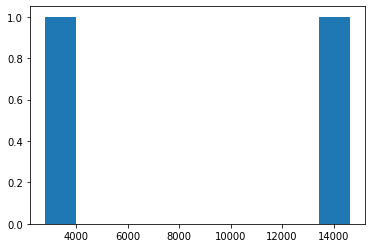

In [18]:
plt.hist([len(no_stock_items),len(little_data_items)])

In [19]:
prev_year    = extrapolate_item[extrapolate_item.date_block_num==(34-12)][['item_id','item_seasonal']]
prev_month_0 = extrapolate_item[extrapolate_item.date_block_num==33][['item_id','item_trend']]
prev_month_1 = extrapolate_item[extrapolate_item.date_block_num==32][['item_id','item_trend']]
prev_month_2 = extrapolate_item[extrapolate_item.date_block_num==31][['item_id','item_trend']]

prev_month = pd.DataFrame()

for item in prev_month_0.item_id.unique()[1:10]:
    t0 = prev_month_0[prev_month_0.item_id == item].item_trend.values[0]
    t1 = prev_month_1[prev_month_1.item_id == item].item_trend.values[0]
    t2 = prev_month_2[prev_month_2.item_id == item].item_trend.values[0]

    fit = np.polyfit([31,32,33], [t2,t1,t0] ,1) # 1 is for linear fit
    line = np.poly1d(fit)

    prev_month = pd.concat([prev_month, pd.DataFrame({'item_id': [item], 'item_trend': [line(34)]})])

    if item%500 == 0:
        plt.plot([t2,t1,t0,line(34)], label='Trend')


month_34 = pd.merge(prev_month, prev_year, how='inner', on=['item_id'])
month_34['date_block_num'] = 34
month_34['item_forecast'] = month_34['item_trend'] + month_34['item_seasonal']

extrapolate_item = pd.concat([extrapolate_item,month_34])
extrapolate_item.shape

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(112817, 5)

In [21]:
# force all out-of-stock items to yeild zero
for item in no_stock_items:

        extrapolate_item = pd.concat([extrapolate_item,
                             pd.DataFrame({
                                 'date_block_num':  range(35),
                                 'item_id':         [item]*35,
                                 'item_trend':      [0]*35,
                                 'item_seasonal':   [0]*35,
                                 'item_forecast':   [0]*35
                             })])

for item in little_data_items:

    sales = item_monthly_sales[item_monthly_sales.item_id==item]

    target_33 = 33 in sales.index and sales.target[33] or 0
    target_32 = 32 in sales.index and sales.target[32] or 0
    target_31 = 31 in sales.index and sales.target[31] or 0

    forecast = (target_33+target_32+target_31)/3.

    extrapolate_item = pd.concat([extrapolate_item,
                             pd.DataFrame({
                                 'date_block_num':  [34],
                                 'item_id':         [item],
                                 'item_trend':      0,
                                 'item_seasonal':   0,
                                 'item_forecast':   forecast
                             })])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [ ]:
item_monthly_sales[item_monthly_sales.item_id==little_data_items[0]]

In [22]:
import gc
del month_34
gc.collect()

9302

In [23]:
all_data = pd.merge(all_data, extrapolate_item, how='left', on=['date_block_num','item_id'])

In [24]:
train = all_data[(all_data.date_block_num>12)&(all_data.date_block_num<34)].fillna(0)

predictors += ['item_trend', 'item_seasonal', 'item_forecast'] 

X_train = train[train.date_block_num <  33][predictors]
X_valid = train[train.date_block_num == 33][predictors]
y_train = train[train.date_block_num <  33].target
y_valid = train[train.date_block_num == 33].target

In [25]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
model2 = RandomForestRegressor(n_estimators=64, max_features=4, n_jobs=4)
model2.fit(X_train, y_train)
ypred = model2.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, ypred))
print("RMSE: %f" % (rmse))

RMSE: 0.985906
CPU times: user 1h 3min 40s, sys: 1min, total: 1h 4min 41s
Wall time: 29min 40s


In [26]:
%%time
from sklearn.ensemble import RandomForestRegressor
full_model2 = RandomForestRegressor(n_estimators=64, max_features=4, n_jobs=6) #len(predictors)/2
full_model2.fit(train[predictors], train.target)

CPU times: user 1h 5min 20s, sys: 56.8 s, total: 1h 6min 17s
Wall time: 20min 32s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=6,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [27]:
month_34 = all_data[all_data.date_block_num == 34].fillna(0)
month_34['item_cnt_month'] = full_model2.predict(month_34[predictors])
test = pd.merge(test_df, month_34, on=["shop_id","item_id"]).fillna(0)

test = test.loc[:,['ID', 'item_cnt_month']]
test.set_index("ID", inplace=True)
test["item_cnt_month"] = test["item_cnt_month"].round().astype("int64")

test[test.item_cnt_month>20] = 20
test.to_csv("shop_item_trends.csv")